In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import os
import dlib
import cv2
import time
import math
import datetime
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import scipy.io
import bz2
from random import randint

In [2]:
if not os.path.exists(os.path.abspath('.') + 'mmod_human_face_detector.dat.bz2'):
    annotation_zip = tf.keras.utils.get_file('mmod_human_face_detector.dat.bz2',
                            cache_subdir=os.path.abspath('.'),
                            origin = "http://dlib.net/files/mmod_human_face_detector.dat.bz2")
# Using pythons bz2 package to read the bz2 file in binary format and write it into a .dat file
with bz2.open("mmod_human_face_detector.dat.bz2", "rb") as f:
    content = f.read()

    with open("mmod_human_face_detector.dat", "wb") as weights_file:
        weights_file.write(content)

os.remove(annotation_zip)

696320/694709 [==============================] - 1s 1us/step


In [3]:
dataset_url = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'
annotation_folder = "wiki_crop"
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('wiki.tar',
                                            cache_subdir=os.path.abspath('.'),
                                            origin = dataset_url,
                                            extract = True)
    os.remove(annotation_zip)
data_key = 'wiki'
mat_file = 'wiki.mat'

811319296/811315200 [==============================] - 76s 0us/step


In [0]:
mat = scipy.io.loadmat(annotation_folder+'/'+mat_file)
data = mat[data_key]
route = data[0][0][2][0]
name = []
age = []
gender = []
images = []
total = 0
project_path = "drive/My Drive/Colab Notebooks/Tutorial/Gender Classifier"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


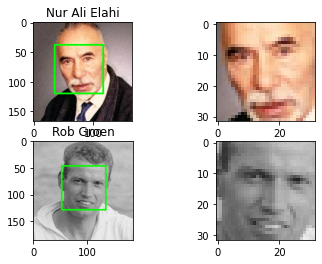

In [9]:
cnn_face_detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
plt.figure()
i = 1

while(i <= 4):
    index = randint(0, len(route))
    if((math.isnan(data[0][0][6][0][index]) == False and data[0][0][6][0][index] > 0)):
        img = cv2.imread('wiki_crop/'+data[0][0][2][0][index][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces_cnn = cnn_face_detector(img, 1)

        for face in faces_cnn:
            offset_x , offset_y  = max(faces_cnn[0].rect.left(),0),max(faces_cnn[0].rect.top(),0)
            target_width, target_height = faces_cnn[0].rect.right() - offset_x, faces_cnn[0].rect.bottom() - offset_y
            target_width = min(target_width, img.shape[1]-offset_x)
            target_height = min(target_height, img.shape[0]-offset_y)
            # draw box over face
            face_img = tf.image.crop_to_bounding_box(img, 
                                                    offset_y, offset_x, 
                                                    target_height,target_width)
            cv2.rectangle(img, (offset_x,offset_y), (offset_x+target_width,offset_y+target_height), (0,255,0), 2)
            face_img = tf.image.resize(face_img, (32, 32), method=tf.image.ResizeMethod.BICUBIC, antialias=True)
            face_img = tf.dtypes.cast(face_img, tf.int32)
            # Plotting images
            plt.subplot(2, 2, i)
            plt.imshow(img)
            plt.title(data[0][0][4][0][index][0])
            plt.subplot(2,2, i+1)
            plt.imshow(face_img)
            i += 2

In [0]:
total = 0
cnn_face_detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
today = datetime.date.today()
for i in range(0,len(route)):
    if i%100 is 0:
        print(i)
    try:
        if((math.isnan(data[0][0][6][0][i]) == False and data[0][0][6][0][i] > 0) and 
        math.isnan(data[0][0][3][0][i]) == False):
            img = cv2.imread(annotation_folder+"/"+route[i][0])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            faces_cnn = cnn_face_detector(img, 1)

            if len(faces_cnn) == 1:

                total += 1
                temp = datetime.date.fromordinal(int(data[0][0][0][0][i])) - datetime.timedelta(days = 366)
                offset_x , offset_y  = max(faces_cnn[0].rect.left(),0),max(faces_cnn[0].rect.top(),0)
                target_width, target_height = faces_cnn[0].rect.right() - offset_x, faces_cnn[0].rect.bottom() - offset_y

                target_width = min(target_width, img.shape[1]-offset_x)
                target_height = min(target_height, img.shape[0]-offset_y)

                face_img = tf.image.crop_to_bounding_box(img, 
                                                        offset_y, offset_x, 
                                                        target_height,target_width)
                
                face_img = tf.image.resize(face_img, (32, 32), method=tf.image.ResizeMethod.BICUBIC, antialias=True)
                face_img = tf.dtypes.cast(face_img, tf.int32)
                
                images.append(face_img.numpy())
                age.append([today.year - temp.year])
                name.append(data[0][0][4][0][i])
                gender.append([data[0][0][3][0][i]])

    except Exception as err:
        print(err)
        print("error in i value ", i)
        if (len(name) == total):
            name.pop()
        if (len(gender) == total):
            gender.pop()
        if (len(age) == total):
            age.pop()
        if (len(images) == total):
            images.pop()
        total -= 1
    
    except KeyboardInterrupt:
        break

print(total, " elements were processed and stored")

In [0]:
meta_data = {
    "images" : images,
    "name" : name,
    #"dob" : dob,
    "age" : age,
    "gender" : gender
}
if not os.path.exists(project_path+"/dataset"):
    os.mkdir(project_path+"/dataset")
binary_file = open(project_path+"/dataset/wiki_data.pickle", "ab")
pickle.dump(meta_data, binary_file )
binary_file.close()